In [1]:
!pip install tensorflow-gpu==2.0.0-beta1

     |████████████████████████████████| 348.9MB 121kB/s 
     |████████████████████████████████| 501kB 29.6MB/s 
     |████████████████████████████████| 3.1MB 17.2MB/s 


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gc
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras import Model, Sequential
from functools import partial
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Conv2DTranspose,\
                                    Reshape, ReLU, LeakyReLU,BatchNormalization, Lambda, \
                                    UpSampling2D, Softmax, Input, Dropout, AvgPool2D, Concatenate, \
                                    LocallyConnected2D, SpatialDropout2D, Activation, InputLayer
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
# Any results you write to the current directory are saved as output.

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

# Variational Ladder AutoEncoder with MMD
Paper link: https://arxiv.org/abs/1702.08396 <br>
While the paper implementation uses as regularizer between $ p(z) $ and $ p(x|z)$  the KL-Leibler divergence with warm up, my personal implementation use Maximum Mean Discrepancy with a rbf kernel
### VLAE representation as graphical model
![](https://i.ibb.co/yp7gwwT/vlae.png)


In [3]:
tf.__version__

'2.0.0-beta1'

# Data loading and preprocessing
I've loaded the MNIST dataset (train and test), separated pixels from labels then normalized in a $[0,1]$ scale

In [4]:
data = pd.read_csv('../input/mnist-in-csv/mnist_train.csv')
test = pd.read_csv('../input/mnist-in-csv/mnist_test.csv')

In [5]:
image_class = data.iloc[:, 0].copy()
images = data.iloc[:, 1:].copy()
del data
gc.collect()
test_image_class = test.iloc[:, 0].copy()
test_images = test.iloc[:, 1:].copy()
del test
gc.collect()

0

In [6]:
images = images.astype('float32')
images = images.values / images.max().max()
test_images = test_images.astype('float32')
test_images = test_images.values / test_images.max().max()

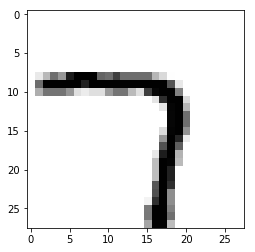

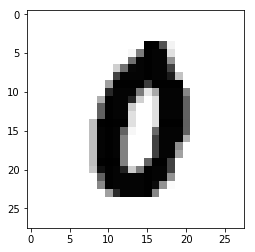

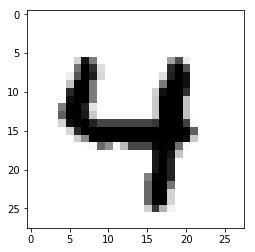

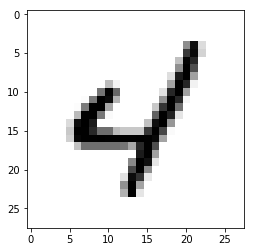

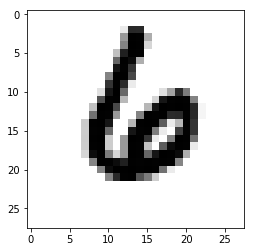

In [7]:
for i in np.random.randint(0,  len(test_images)-1, 5):
    plt.imshow(test_images[i].reshape((28,28)), cmap='gray_r')
    plt.show()

# VLAE Definition

## Normal Stocastic layer
This custom layer implements the variational layer with Normal distribution following the [original paper of VAE](https://arxiv.org/abs/1312.6114) <br>
Down below the graph representation of this layer
![](https://i.ibb.co/5MVC3Yg/normal-variational.png) 
The class constructor allows to:
- specify the size of the multivariate normal
- set prior mean and variance
- add to loss kl divergence and its coefficient
- add to loss MMD (Maximum Mean Discrepancy), its coefficient and the kernel (by default rbf). The class implements itself yet both linear and rbf kernel ([implementation taken from InfoVAE authors](https://ermongroup.github.io/blog/a-tutorial-on-mmd-variational-autoencoders))
- show as metric mean posterior $\mu$ and $\sigma^2$ to check if the regularization part works well

In [8]:
class NormalVariational(tf.keras.layers.Layer):
    
    def __init__(self, size, mu_prior=0., sigma_prior=1., add_kl=True, coef_kl = 1.0, add_mmd=False, lambda_mmd=1.0, kernel_f=None, name=None, show_posterior=True):
        super().__init__(name=name)
        self.mu_layer = tf.keras.layers.Dense(size)
        self.sigma_layer = tf.keras.layers.Dense(size)
        self.add_kl = add_kl
        self.mu_prior = tf.constant(mu_prior, dtype=tf.float32, shape=(size,))
        self.sigma_prior = tf.constant(sigma_prior, dtype=tf.float32, shape=(size,))
        self.show_posterior = show_posterior
        self.coef_kl = tf.Variable(coef_kl, trainable=False, name='coef_kl')
        self.add_mmd = add_mmd
        if kernel_f is None:
            self.kernel_f = self._rbf
        else:
            self.kernel_f = kernel_f
        self.lambda_mmd = lambda_mmd
            
    def _rbf(self, x, y):
        x_size = tf.shape(x)[0]
        y_size = tf.shape(y)[0]
        dim = tf.shape(x)[1]
        tiled_x = tf.tile(tf.reshape(x, tf.stack([x_size, 1, dim])), tf.stack([1, y_size, 1]))
        tiled_y = tf.tile(tf.reshape(y, tf.stack([1, y_size, dim])), tf.stack([x_size, 1, 1]))
        return tf.exp(-tf.reduce_mean(tf.square(tiled_x - tiled_y), axis=2) / tf.cast(dim, tf.float32))
    
    def _linear(self, x,y):
        return tf.reduce_sum(tf.multiply(x,y))
        
    def add_kl_divergence(self, mu1, sigma1, mu2, sigma2):
            logsigma1, logsigma2 = tf.math.log(sigma1), tf.math.log(sigma2)
            mu_diff = mu1 - mu2
            kl = self.coef_kl * \
                tf.reduce_sum(logsigma1 - logsigma2 - 1. + (sigma2 + tf.square(mu_diff)) / sigma1, axis=1)
            kl = tf.reduce_mean(kl)
            self.add_loss(kl)
            self.add_metric(kl, 'mean', 'kl_divergence')

    def call(self, inputs):
        mu = self.mu_layer(inputs)
        log_sigma =  self.sigma_layer(inputs)
        sigma_square = tf.exp(log_sigma)
        if self.add_kl:
            self.add_kl_divergence(mu, sigma_square, self.mu_prior, self.sigma_prior)
        if self.show_posterior:
            self.add_metric(mu, 'mean', 'mu_posteror')
            self.add_metric(sigma_square, 'mean', 'sigma^2_posterior')
        z = mu + sigma_square * tf.random.normal(tf.shape(sigma_square))
        if self.add_mmd:
            z_prior = tfp.distributions.MultivariateNormalDiag(self.mu_prior, self.sigma_prior).sample(tf.shape(z)[0])
            print(z_prior)
            print(z)
            k_prior = self.kernel_f(z_prior, z_prior)
            k_post = self.kernel_f(z, z)
            k_prior_post = self.kernel_f(z_prior, z)
            mmd = tf.reduce_mean(k_prior) + tf.reduce_mean(k_post) - 2 * tf.reduce_mean(k_prior_post)
            mmd = tf.multiply(self.lambda_mmd,  mmd, name='mmd')
            self.add_loss(mmd)
            self.add_metric(mmd, 'mean', 'mmd')
        return z


In [9]:
tf.keras.backend.clear_session()
gc.collect()

10804

## Network definition
1. Layers between the input, $h_1, h_2, h_3$ are sequences of a convolutional layer, batch normalization and relu. 
2. Sometimes there is a SpatialDroput layer to make the model more robust
3. The encoder part output $h_1, h_2, h_3$ that are given in input respectively to $z_1, z_2, z_3$, three normal stochastic layers
4. Then $\widetilde{z}_3$ is obtained from $z_3$ with three Dense/BN/Relu with size 1024
5. $\widetilde{z}_2$ receive in input the concatenation of $[\widetilde{z}_3, g(z_2)]$ where $g(\cdot)$ is a neural network; <br>
in my case is a single Dense layer with relu activation
5. $\widetilde{z}_1$ receive in input the concatenation of $[\widetilde{z}_2, g(z_1)]$ where $g(\cdot)$ is a neural network; <br>
in my case is a single Dense layer with relu activation
6. From $\widetilde{z}_1$ starts the effective decoder part, that increase the size until the original one. Differently from the original paper, i've used UpSampling2D/Conv2D instead of Transpose convolution because produce less artifacts  <br><br>
Note: Since the learnable params of batch norm gives every training NaN values into it i've virtually removed setting trainable=False into every BatchNorm layer; honestly i don't understood exactly the NaN reason, maybe the stochasticity of this neural network 

In [10]:
def make_encoder(latent_size):
    droput_rate = 0.05
    inputs = Input((28,28,1))
    with tf.name_scope('h_1'):
        h_1_layers = Sequential([ 
            Input((28, 28, 1)),
            Conv2D(8, 3),
            BatchNormalization(trainable=False),
            ReLU(),
            Conv2D(16, 3),
            BatchNormalization(trainable=False),
            SpatialDropout2D(droput_rate),
            ReLU()], name='h_1')
        h_1 = h_1_layers(inputs)
        h_1_flatten = Flatten()(h_1)
    with tf.name_scope('h_2'):
        h_2_layers = Sequential([ 
            Conv2D(16, 3),
            BatchNormalization(trainable=False),
            ReLU(),
            Conv2D(16, 3),
            BatchNormalization(trainable=False),
            SpatialDropout2D(droput_rate),
            ReLU()], name='h_2')
        h_2 = h_2_layers(h_1)
        h_2_flatten = Flatten()(h_2)
    with tf.name_scope('h_3'):
        h_3_layers = Sequential([ 
            Conv2D(16, 3),
            BatchNormalization(trainable=False),
            ReLU(),
            Conv2D(16, 3),
            BatchNormalization(trainable=False),
            SpatialDropout2D(droput_rate),
            ReLU()], name='h_3')
        h_3 = h_3_layers(h_2)
        h_3_flatten = Flatten()(h_3)
    return Model(inputs, [h_1_flatten, h_2_flatten, h_3_flatten], name='encoder')
        
def make_decoder(latent_dim1, latent_dim2, latent_dim3):
    z_1_input, z_2_input, z_3_input = Input((latent_dim1,), name='z_1'), Input((latent_dim2,), name='z_2'), Input((latent_dim3,), name='z_3')
    
    with tf.name_scope('z_tilde_3'):
        z_3 = Dense(1024, activation='relu')(z_3_input)
        z_tilde_3_layers = Sequential([
            Dense(1024),
            BatchNormalization(trainable=False),
            ReLU()] * 3, name='z_tilde_3')
        z_tilde_3 = z_tilde_3_layers(z_3)
        
    with tf.name_scope('z_tilde_2'):
        z_2 = Dense(128, activation='relu')(z_2_input)
        z_tilde_2_layers = Sequential([
            Dense(128),
            BatchNormalization(trainable=False),
             ReLU()] * 3, name='z_tilde_2')
        input_z_tilde_2 = Concatenate()([z_tilde_3, z_2])
        z_tilde_2 =  z_tilde_2_layers(input_z_tilde_2)
    
    with tf.name_scope('z_tilde_1'):
        z_1 = Dense(128, activation='relu')(z_1_input)
        z_tilde_1_layers = Sequential([
            Dense(128),
            BatchNormalization(trainable=False),
             ReLU()] * 3, name='z_tilde_1')
        input_z_tilde_1 = Concatenate()([z_tilde_2, z_1])
        z_tilde_1 =  z_tilde_1_layers(input_z_tilde_1)
        
    with tf.name_scope('decoder'):
        decoder = Reshape((2,2,32))(z_tilde_1)
        decoder = UpSampling2D(2)(decoder) #4x4
        decoder = Conv2D(32, 3)(decoder) #2x2
        decoder = BatchNormalization(trainable=False)(decoder)
        decoder = Activation(tf.nn.crelu)(decoder)
        decoder = UpSampling2D(4)(decoder) #8x8
        decoder = Conv2D(16, 3)(decoder) #6x6
        decoder = BatchNormalization(trainable=False)(decoder)
        decoder = Activation(tf.nn.crelu)(decoder)
        decoder = UpSampling2D(2)(decoder) #12x12
        decoder = Conv2D(8, 3)(decoder) #10x10
        decoder = BatchNormalization(trainable=False)(decoder)
        decoder = Activation(tf.nn.crelu)(decoder)
        decoder = UpSampling2D(2)(decoder) #20x20
        decoder = Conv2D(4, 5)(decoder) #16x16
        decoder = BatchNormalization(trainable=False)(decoder)
        decoder = LeakyReLU()(decoder)
        decoder = UpSampling2D(2)(decoder) #32x32
        decoder = Conv2D(1, 5)(decoder) #28x28
        decoder = Activation('sigmoid')(decoder)
    return Model([z_1_input, z_2_input, z_3_input], decoder, name='decoder')

def make_vlae(latent_size):
    with tf.name_scope('encoder'):
        encoder = make_encoder(latent_size)
    with tf.name_scope('decoder'):
        decoder = make_decoder(latent_size, latent_size, latent_size)
    inputs = Input((28,28,1))
    h_1, h_2, h_3 = encoder(inputs)
    z_1 = NormalVariational(latent_size, add_kl=False, coef_kl=0.0, add_mmd=True, lambda_mmd=1., name='z_1_latent')(h_1)
    z_2 = NormalVariational(latent_size, add_kl=False, coef_kl=0.0, add_mmd=True, lambda_mmd=1., name='z_2_latent')(h_2)
    z_3 = NormalVariational(latent_size, add_kl=False, coef_kl=0.0, add_mmd=True, lambda_mmd=10., name='z_3_latent')(h_3)
    
    decoded = decoder([z_1, z_2, z_3])
    vlae = Model(inputs, decoded, name='vlae')
    return vlae

In [11]:
latent_size = 2
vlae = make_vlae(latent_size)

Tensor("z_1_latent/MultivariateNormalDiag/sample/affine_linear_operator/forward/add:0", shape=(None, 2), dtype=float32)
Tensor("z_1_latent/add:0", shape=(None, 2), dtype=float32)
Tensor("z_2_latent/MultivariateNormalDiag/sample/affine_linear_operator/forward/add:0", shape=(None, 2), dtype=float32)
Tensor("z_2_latent/add:0", shape=(None, 2), dtype=float32)
Tensor("z_3_latent/MultivariateNormalDiag/sample/affine_linear_operator/forward/add:0", shape=(None, 2), dtype=float32)
Tensor("z_3_latent/add:0", shape=(None, 2), dtype=float32)


In [12]:
vlae.summary()

Model: "vlae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 9216), (None 10880       input_3[0][0]                    
__________________________________________________________________________________________________
z_1_latent (NormalVariational)  (None, 2)            36869       encoder[1][0]                    
__________________________________________________________________________________________________
z_2_latent (NormalVariational)  (None, 2)            25605       encoder[1][1]                    
_______________________________________________________________________________________________

In [13]:
def flatten_binary_crossentropy(x,xhat):
    return 10 * tf.losses.binary_crossentropy(Flatten()(x), Flatten()(xhat))

vlae.compile(tf.keras.optimizers.Adam(), flatten_binary_crossentropy)

### KL Warm Up

Keras Callback that implements KL Warm Up for stocastic layers. <br>
Unfortunately the current implementation of this callback is code dependent because use the pre-defined names of stochastic layers to find they
<br>
Basically the KL Warm Up constist in set the coefficient before KL divergence to 0 on the first epochs in order to allow the model to properly learn the encoder/decoder part. Then after a specified epoch the coefficient starts to increase until a maximum<br>
All this parameters can be setted in the constructor of this class

In [14]:
class KLWarmUp(tf.keras.callbacks.Callback):
    
    def __init__(self, vlae, start_epoch = 1, max_value = 1.0, delta = 0.05):
        self.start_epoch = start_epoch
        self.max_value = 1.0
        self.delta = delta 
        self.epoch = 0
        self.vlae = vlae
        
    def on_epoch_end(self, *args, **kwargs):
        self.epoch += 1
        if self.start_epoch <= self.epoch:
            coefs = [self.vlae.get_layer(f'z_{i+1}_latent').coef_kl for i in range(3)]
            for coef in coefs:
                if coef <= self.max_value:
                    coef.assign_add(self.delta)

# Training
* If you create a kernel from the output of this one you can use tensorboard to visualize the learning of the model
* The learning rate is log uniform between 0.0012 and 0.00001; before i've tried higher lr but the convergence was worse
* EarlyStopping if the validation loss doesn't improve for 15 epochs of 0.001
* 200 epochs, batch_size=256

In [15]:
from tensorflow.keras.callbacks import TensorBoard, LearningRateScheduler, EarlyStopping
tb = TensorBoard(write_grads=True, write_images=False, write_graph=True, histogram_freq=2)
es = EarlyStopping(min_delta=0.001, patience=15)
# klwarmup = KLWarmUp(vlae, start_epoch=30, max_value=0.33)

In [16]:
epochs = 200
lr_epochs = 10 ** np.linspace(-2.9, -4, epochs)
lrsched = LearningRateScheduler(lambda i: lr_epochs[i])

In [17]:
images = images.reshape((-1, 28, 28, 1))
test_images = test_images.reshape((-1, 28, 28, 1))

In [18]:
vlae.fit(images, images, batch_size=256, epochs=epochs, callbacks=[lrsched, tb, es], validation_data=(test_images, test_images))

Train on 60000 samples, validate on 10000 samples
Epoch 1/200
60000/60000 [==============================] - 24s 407us/sample - loss: 2.7912 - mu_posteror: 0.0034 - sigma^2_posterior: 0.9907 - mmd: 0.0382 - val_loss: 2.5127 - val_mu_posteror: -0.0025 - val_sigma^2_posterior: 0.9872 - val_mmd: 0.0714
Epoch 2/200
60000/60000 [==============================] - 13s 224us/sample - loss: 2.3569 - mu_posteror: -0.0051 - sigma^2_posterior: 0.9900 - mmd: 0.0391 - val_loss: 2.2183 - val_mu_posteror: -0.0057 - val_sigma^2_posterior: 0.9981 - val_mmd: 0.0495
Epoch 3/200
60000/60000 [==============================] - 14s 229us/sample - loss: 2.1352 - mu_posteror: -0.0042 - sigma^2_posterior: 0.9953 - mmd: 0.0388 - val_loss: 2.0583 - val_mu_posteror: -0.0067 - val_sigma^2_posterior: 0.9891 - val_mmd: 0.0483
Epoch 4/200
60000/60000 [==============================] - 13s 219us/sample - loss: 2.0034 - mu_posteror: 0.0012 - sigma^2_posterior: 0.9979 - mmd: 0.0403 - val_loss: 1.9260 - val_mu_posteror: 0.

In [19]:
tf.saved_model.save(vlae, 'mikedev_vlae')

Tensor("vlae/z_1_latent/MultivariateNormalDiag/sample/affine_linear_operator/forward/add:0", shape=(None, 2), dtype=float32)
Tensor("vlae/z_1_latent/add:0", shape=(None, 2), dtype=float32)
Tensor("vlae/z_2_latent/MultivariateNormalDiag/sample/affine_linear_operator/forward/add:0", shape=(None, 2), dtype=float32)
Tensor("vlae/z_2_latent/add:0", shape=(None, 2), dtype=float32)
Tensor("vlae/z_3_latent/MultivariateNormalDiag/sample/affine_linear_operator/forward/add:0", shape=(None, 2), dtype=float32)
Tensor("vlae/z_3_latent/add:0", shape=(None, 2), dtype=float32)
Tensor("MultivariateNormalDiag/sample/affine_linear_operator/forward/add:0", shape=(None, 2), dtype=float32)
Tensor("add:0", shape=(None, 2), dtype=float32)
Tensor("MultivariateNormalDiag/sample/affine_linear_operator/forward/add:0", shape=(None, 2), dtype=float32)
Tensor("add:0", shape=(None, 2), dtype=float32)
Tensor("MultivariateNormalDiag/sample/affine_linear_operator/forward/add:0", shape=(None, 2), dtype=float32)
Tensor("ad

# Generation
In order to generate is sufficient sample from the prior (in my case a N(0,1)) three times because there are three latent variable in this model <br>
Then feed into the VLAE-decoder this three random sampled values 

In [20]:
sample = [np.random.multivariate_normal([0] * latent_size, np.diag([1] * latent_size), 20)] * 3

In [21]:
generated = vlae.get_layer('decoder').predict(sample)

In [22]:
generated = generated.reshape((20, 28, 28))

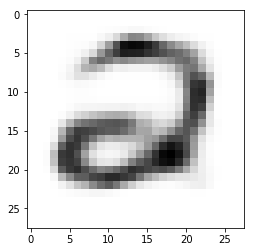

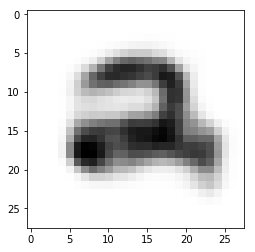

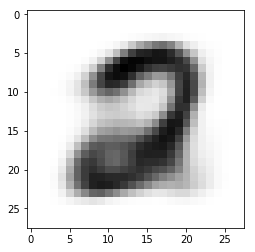

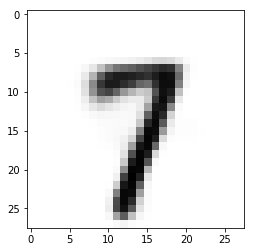

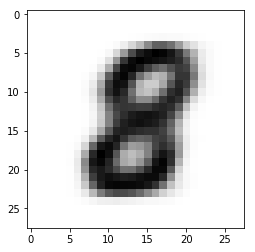

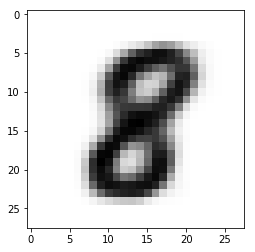

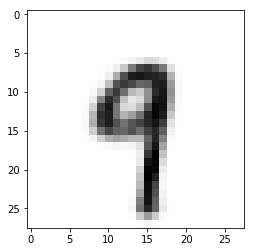

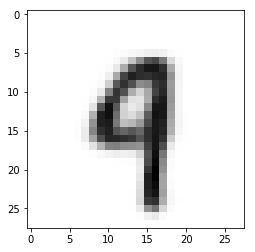

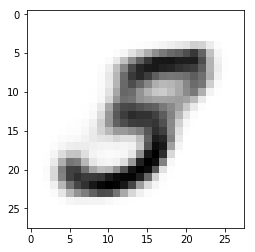

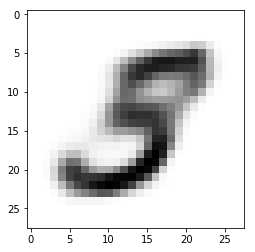

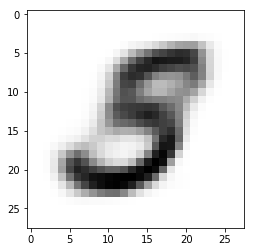

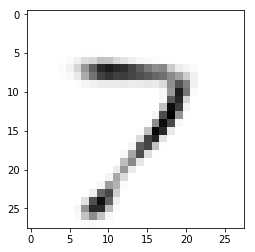

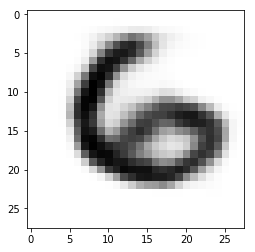

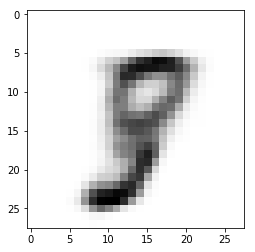

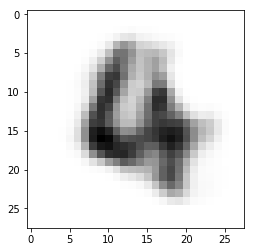

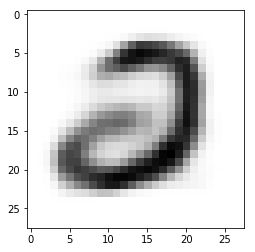

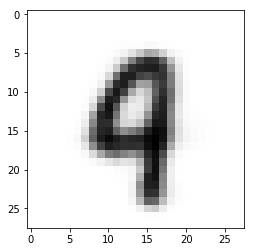

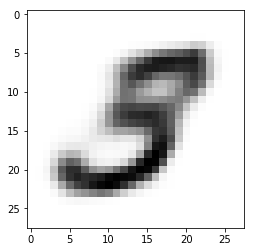

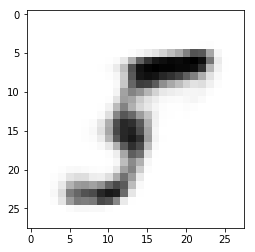

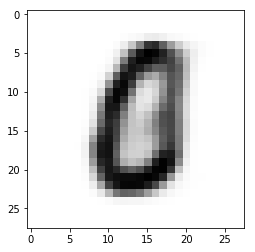

In [23]:
for i in range(20):
    img = generated[i, :, :]
    plt.imshow(img, cmap='gray_r')
    plt.show()

# Future improvements
* Use the label as additional information to improve the recostruction